# MNIST dataset classification

In [2]:
import scipy.io as sio
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import math
import csv
from pylab import pcolor, show, colorbar, xticks, yticks

## Data partitioning

In [3]:
# Read in the file
train_mat = sio.loadmat("train.mat")
print(train_mat)

{'__version__': '1.0', 'trainX': array([[0, 0, 0, ..., 0, 0, 5],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 4],
       ..., 
       [0, 0, 0, ..., 0, 0, 5],
       [0, 0, 0, ..., 0, 0, 6],
       [0, 0, 0, ..., 0, 0, 8]]), '__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Fri Jan 20 17:22:08 2017', '__globals__': []}


In [4]:
# Understand the data content
train_mat.keys()

dict_keys(['__version__', 'trainX', '__header__', '__globals__'])

In [5]:
# Get the training data
data_set = train_mat['trainX']
data_set

array([[0, 0, 0, ..., 0, 0, 5],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 4],
       ..., 
       [0, 0, 0, ..., 0, 0, 5],
       [0, 0, 0, ..., 0, 0, 6],
       [0, 0, 0, ..., 0, 0, 8]])

In [6]:
# Check the amount of data in the training set
data_set.shape

(60000, 785)

In [7]:
# Shuffle the whole provided data set
np.random.shuffle(data_set)

In [8]:
# Set aside 10000 training images as a validation set
validation_index = np.array(random.sample(range(data_set.shape[0]), 10000))
validation_set = data_set[validation_index]

In [9]:
# Verify the validation set size
validation_set.shape

(10000, 785)

In [10]:
# Construct the training set
training_set = np.delete(data_set, validation_index, 0)
print(training_set.shape)

(50000, 785)


In [11]:
# Normalize the given data
def normalize_data(data):
    normalized_data = data/np.linalg.norm(data).reshape((-1, 1))
    return normalized_data

Separate labels and data

In [13]:
# Construct the training set
training_set = np.delete(data_set, validation_index, 0)
print(training_set.shape)

# Separate the label and data
training_labels = training_set[:, 784]
training_data = training_set[:, 0:784]
validation_labels = validation_set[:, 784]
validation_data = validation_set[:, 0:784]
print(validation_labels.shape)
print(validation_data.shape)

(50000, 785)
(10000,)
(10000, 784)


In [14]:
# Normalize the data
norm_validation_data = normalize_data(validation_data)


norm_training_data = normalize_data(training_data)

## (a) Gaussian Distribution Fitting

Maximum likelihood estimation: 

mean: $\hat{\mu}_c = \frac{1}{n_c} \sum_{i=1}^n x_i$, covatiance: $\hat{\Sigma}_c = \frac{1}{n_c}\sum_{i=1}^n(X_i-\mu_c)(X_i-\mu_c)^T$

In [15]:
# Compute the mean
classes = 10
means = [np.mean(norm_training_data[training_labels == c], axis=0) for c in range(classes)]

In [16]:
# Compute the covariance matrix
covariance = [np.cov(norm_training_data[training_labels == c].T) for c in range(classes)]

## (b) Covariance Matrix Plotting

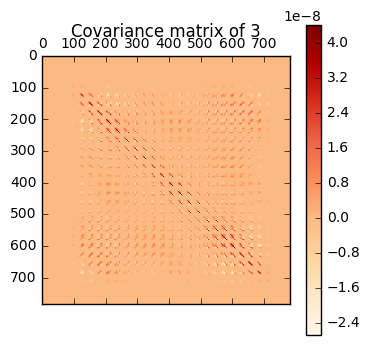

In [17]:
cov_to_plot = 3
plt.matshow(covariance[cov_to_plot], interpolation="nearest", cmap=plt.cm.OrRd)
plt.title("Covariance matrix of {}".format(cov_to_plot))
plt.colorbar()
plt.show()

The values in the diagonoal are greater. The correlation become weaker in general as the feature gets further away from each other. And the features in the two ends have almost no correlations with any others.

## (c) Classification

In [21]:
def cross_validation(training_data, training_labels, DA_fn, k_fold, constant):
    """
    Do the k-fold cross_validation with given discriminate analysis function
    and the constant that modify the covariance matrix
    It returns the average validation accuracy with the given constant
    """
    # Partition the data and labels into k-fold
    data_set = np.array(np.split(training_data, k_fold))
    labels_set = np.array(np.split(training_labels, k_fold))
    total_accuracy = []
    
    for k in range(k_fold):
        train_data = np.delete(data_set, k, 0)
        train_labels = np.delete(labels_set, k, 0)
        validation_data = data_set[k]
        validation_labels = labels_set[k]
        validation_prediction = DA_fn(train_data, train_labels, validation_data, constant)
        total_accuracy.append(np.sum(validation_prediction == validation_labels)/float(len(validation_labels)))
    accuracy = sum(total_accuracy)/len(total_accuracy)
    return accuracy

### (i) LDA

In [18]:
feature_size = 784
avg_cov = np.mean(covariance, axis=0) # the average covariance matrix of the 10 classes, avg_cov.shape = (784, 784)

In [19]:
# Calculate the prior probability
sample_size = float(training_labels.shape[0])
prior_prob = [np.sum(training_labels == c)/sample_size for c in range(classes)]
for i, p in enumerate(prior_prob):
    print("Prior of ", i, " is ", p)

Prior of  0  is  0.09876
Prior of  1  is  0.11308
Prior of  2  is  0.09942
Prior of  3  is  0.10074
Prior of  4  is  0.0976
Prior of  5  is  0.09038
Prior of  6  is  0.09912
Prior of  7  is  0.1046
Prior of  8  is  0.09716
Prior of  9  is  0.09914


Choose a label C that maximizes the linear discriminant function: $\mu_c^T\Sigma^{-1}x - \frac{1}{2}\mu_c^T\Sigma^{-1}\mu_c+ln(\pi_c)$


In [20]:
def LDA(training_data, training_labels, prediction_data, constant):
    # Compute the mean
    classes = 10
    means = [np.mean(training_data[training_labels == c], axis=0) for c in range(classes)]
    # Compute the covariance matrix
    covariance = [np.cov(training_data[training_labels == c].T) for c in range(classes)]
    avg_cov = np.mean(covariance, axis=0) + np.eye(feature_size) * constant# the average covariance matrix of the 10 classes
    avg_cov_inv = np.linalg.inv(avg_cov) 
    
    # use the linear discriminant function to make prediction
    predictions = [means[c].dot(avg_cov_inv).dot(prediction_data.T) - \
                   0.5 * means[c].T.dot(avg_cov_inv).dot(means[c]) + \
                   np.log(prior_prob[c]) for c in range(classes)]
    max_prediction = np.argmax(predictions, axis=0)
    return max_prediction

In [31]:
def find_best_const(training_data, training_labels, DA_fn, k_fold, constant_list):
    """
    Find the best constant that results in a greater accuracy in the constant list
    """
    max_accuracy = 0
    best_const = 0
    
    for const in constant_list:
        print("Testing const", const)
        current_accuracy = cross_validation(training_data, training_labels, DA_fn, k_fold, const)
        if current_accuracy > max_accuracy:
            max_accuracy = current_accuracy
            best_const = const
    return best_const

In [23]:
constant_list = np.array([10**i for i in range(-10, -2)])
k_fold = 5
LDA_best_const = find_best_const(norm_training_data, training_labels, LDA, k_fold, constant_list)
print("Best constant is", LDA_best_const)

Best constant is 1e-08


In [24]:
# Tunning the hyperparameter with different training size
training_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
LDA_validation_error = []
for size in training_sizes:
    LDA_validation_prediction = LDA(norm_training_data[:size], training_labels[:size],\
                                    norm_validation_data, LDA_best_const)
    error_rate = np.sum(LDA_validation_prediction != validation_labels)/float(len(validation_labels))
    LDA_validation_error.append(error_rate)

In [25]:
LDA_validation_error

[0.3246,
 0.24179999999999999,
 0.18410000000000001,
 0.15390000000000001,
 0.14149999999999999,
 0.13880000000000001,
 0.13819999999999999,
 0.13639999999999999,
 0.13769999999999999]

Plot the validation error

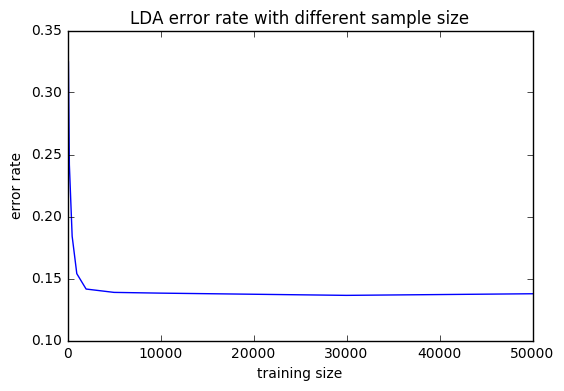

In [26]:
plt.title("LDA error rate with different sample size")
plt.xlabel("training size")
plt.ylabel("error rate")
plt.plot(training_sizes, LDA_validation_error)
plt.show()

### (ii) QDA

Choose a class C that maximizes $P(X=x|Y=c)\pi_c$ is equivalent to maximizing the quadratic discriminant function: $Q_c = -\frac{1}{2}(x-\mu_c)^T\Sigma_c^{-1}(x-\mu_c)-\frac{1}{2}ln|\Sigma_c|+ln(\pi_c)$

In [29]:
def QDA(training_data, training_labels, prediction_data, constant):
    # Compute the mean
    classes = 10
    expand_size = len(prediction_data)
    means = [np.mean(training_data[training_labels == c], axis=0) for c in range(classes)]
    # Transform the means into a list of matrix that with each row is a replica of mean
    means_transformed = [np.tile(mean.reshape(784, 1), expand_size).T \
                                  for mean in means]
    # Compute the covariance matrix
    covariances = [np.cov(training_data[training_labels == c].T) + np.eye(feature_size) * constant\
                   for c in range(classes)]
    cov_invs = [np.linalg.inv(cov) for cov in covariances]
    
    # use the linear discriminant function to make prediction
    predictions = [-0.5 * (prediction_data - means_transformed[c]).dot(cov_invs[c])\
                   .dot((prediction_data - means_transformed[c]).T).diagonal() - \
                   0.5 * np.tile(np.log(np.linalg.norm(cov_invs[c])), expand_size) + \
                   np.tile(np.log(prior_prob[c]), expand_size) for c in range(classes)]
    max_prediction = np.argmax(predictions, axis=0)
    return max_prediction

In [32]:
constant_list = [10**i for i in range(-10, 0)]
QDA_best_const = find_best_const(norm_training_data, training_labels, QDA, k_fold, constant_list)
print("Best constant is", QDA_best_const) #1e-07

Testing const 1e-10
Testing const 1e-09
Testing const 1e-08
Testing const 1e-07
Testing const 1e-06
Testing const 1e-05
Testing const 0.0001
Testing const 0.001
Testing const 0.01
Testing const 0.1
Best constant is 1e-07


In [33]:
QDA_validation_error = []
for size in training_sizes:
    print(size)
    QDA_validation_prediction = QDA(norm_training_data[:size], training_labels[:size],\
                                    norm_validation_data, QDA_best_const)
    error_rate = np.sum(QDA_validation_prediction != validation_labels)/float(len(validation_labels))
    QDA_validation_error.append(error_rate)

100
200
500
1000
2000
5000
10000
30000
50000


In [34]:
QDA_validation_error

[0.34460000000000002,
 0.23599999999999999,
 0.1019,
 0.067000000000000004,
 0.0562,
 0.051499999999999997,
 0.049099999999999998,
 0.049099999999999998,
 0.048899999999999999]

Plot the validation error

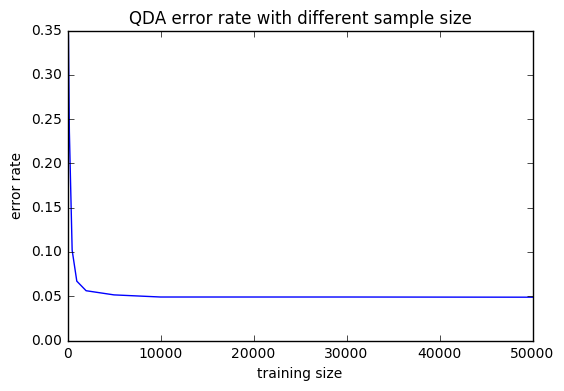

In [35]:
plt.title("QDA error rate with different sample size")
plt.xlabel("training size")
plt.ylabel("error rate")
plt.plot(training_sizes, QDA_validation_error)
plt.show()

## Kaggle Prediction

In [36]:
# Read in the test file
best_const = QDA_best_const
test_mat = sio.loadmat("test.mat")
print(test_mat)
print(test_mat.keys())

{'__version__': '1.0', 'testX': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), '__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Fri Jan 20 17:22:25 2017', '__globals__': []}
dict_keys(['__version__', 'testX', '__header__', '__globals__'])


In [37]:
test_data = test_mat['testX']

# Normalize the test data
norm_test_data = normalize_data(test_data)

predictions = QDA(norm_training_data, training_labels, norm_test_data, best_const)

In [38]:
i = 0
with open('mnist_submission.csv', 'w', newline='') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['Id'] + ['Category'])
    for num in predictions:
        writer.writerow([i] + [num])
        i += 1